# Задание.

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [ ]:
sales_of_company_x = pd.read_csv('/content/monthly-sales-of-company-x-jan-6.csv')
robberies_in_boston = pd.read_csv('/content/monthly-boston-armed-robberies-j.csv')
airlines_passengers = pd.read_csv("/content/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("/content/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("/content/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

In [3]:
print(sales_of_company_x.columns)
print(robberies_in_boston.columns)
print(airlines_passengers.columns)
print(female_births.columns)
print(mean_monthly_temp.columns)
print(dowjones_closing.columns)


Index(['Month', 'Count'], dtype='object')
Index(['Month', 'Count'], dtype='object')
Index(['Month', 'Count'], dtype='object')
Index(['Date', 'Count'], dtype='object')
Index(['Month', 'Deg'], dtype='object')
Index(['Week', 'Close'], dtype='object')


# 1. Нетационарный временной ряд.

       Month  Count
0 1965-01-01    154
1 1965-02-01     96
2 1965-03-01     73
3 1965-04-01     49
4 1965-05-01     36


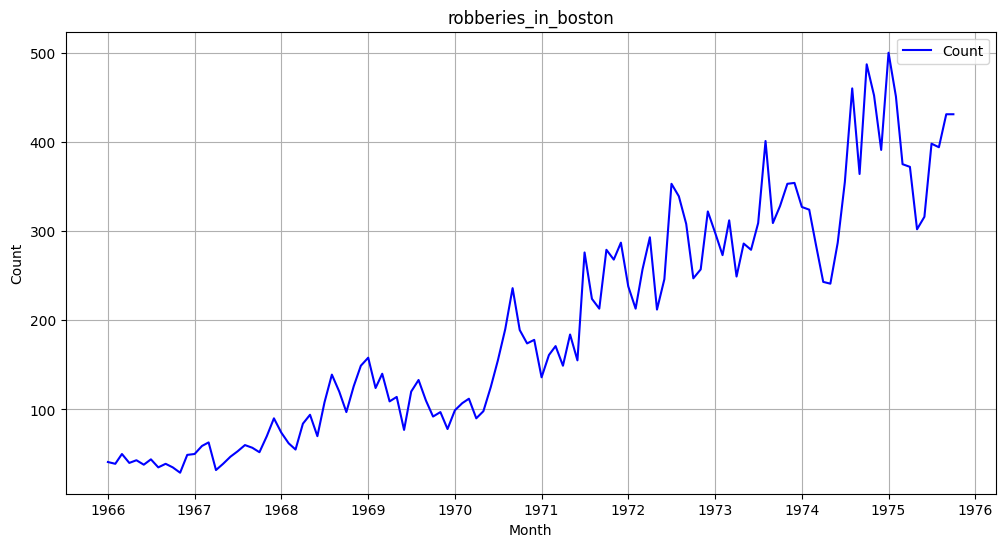

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
robberies_in_boston = pd.read_csv('/content/monthly-boston-armed-robberies-j.csv')

# Проверим структуру данных
print(sales_of_company_x.head())

# Преобразуем колонку 'Month' в формат даты

robberies_in_boston['Month'] = pd.to_datetime(robberies_in_boston['Month'])

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(robberies_in_boston['Month'],robberies_in_boston['Count'], color='blue', label='Count')
plt.title('robberies_in_boston')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-41-88887cbd2585>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - series[i]) / season_len)
<ipython-input-41-88887cbd2585>:64: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=robberies_in_boston.index[-1], periods=n_preds + 1, freq='M')[1:]


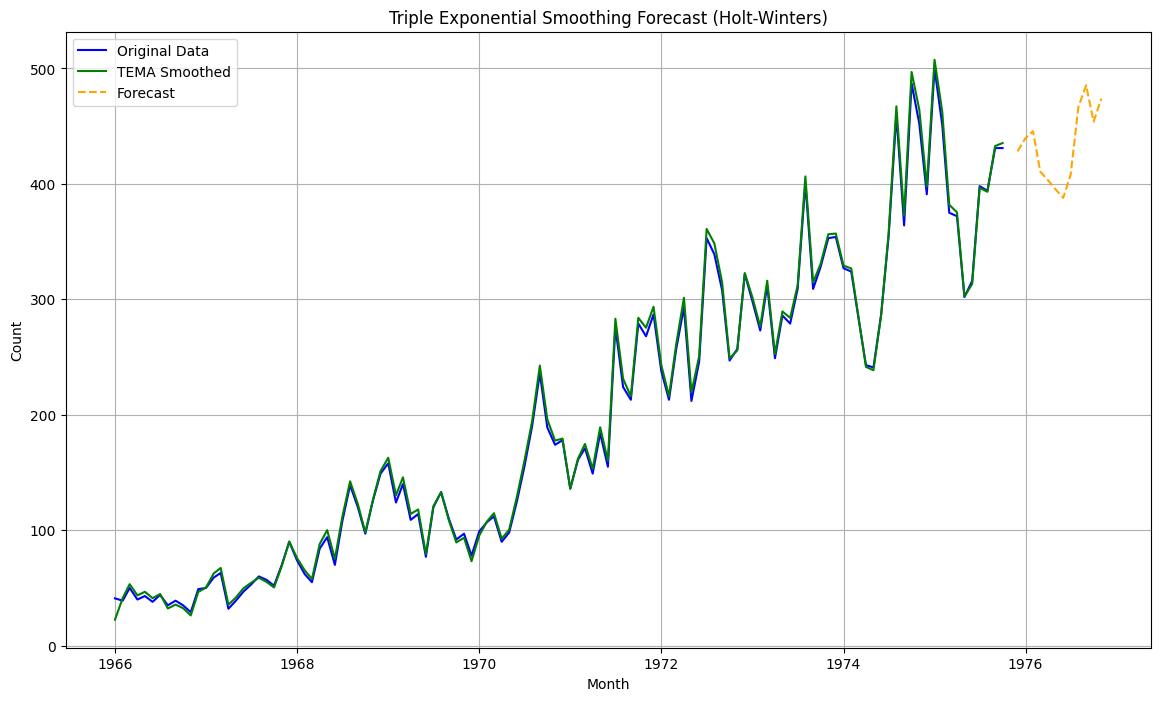

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Функция для вычисления начального тренда
def initial_trend(series, season_len):
    trend_sum = 0.0
    for i in range(season_len):
        trend_sum += (float(series[i + season_len] - series[i]) / season_len)
    return trend_sum / season_len

# Функция для вычисления начальных сезонных компонентов
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series.iloc[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

# Функция для тройного экспоненциального сглаживания
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    smooth = series.iloc[0]
    trend = initial_trend(series, slen)
    result.append(smooth + trend + seasonals[0])

    for i in range(1, len(series) + n_preds):
        if i >= len(series):  # Прогнозирование
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
        else:
            val = series.iloc[i]
            last_smooth, smooth = smooth, alpha * (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * (val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth + trend + seasonals[i % slen])

    return result

# Загрузка данных
robberies_in_boston = pd.read_csv('/content/monthly-boston-armed-robberies-j.csv')
robberies_in_boston['Month'] = pd.to_datetime(robberies_in_boston['Month'])
robberies_in_boston.set_index('Month', inplace=True)

# Параметры модели
season_len = 12
alpha, beta, gamma =0.8, 0.1, 0.8
n_preds = 12  # Прогноз на 12 месяцев

# Применяем тройное экспоненциальное сглаживание
result = triple_exponential_smoothing(robberies_in_boston['Count'], season_len, alpha, beta, gamma, n_preds)

# Добавление сглаженного ряда к исходным данным
robberies_in_boston['TEMA_Smoothed'] = result[:len(robberies_in_boston)]

# Создание диапазона дат для прогноза
forecast_index = pd.date_range(start=robberies_in_boston.index[-1], periods=n_preds + 1, freq='M')[1:]

# Визуализация
plt.figure(figsize=(14, 8))
plt.plot(robberies_in_boston['Count'], label='Original Data', color='blue')
plt.plot(robberies_in_boston['TEMA_Smoothed'], label='TEMA Smoothed', color='green')
plt.plot(forecast_index, result[-n_preds:], label='Forecast', color='orange', linestyle='dashed')
plt.title('Triple Exponential Smoothing Forecast (Holt-Winters)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


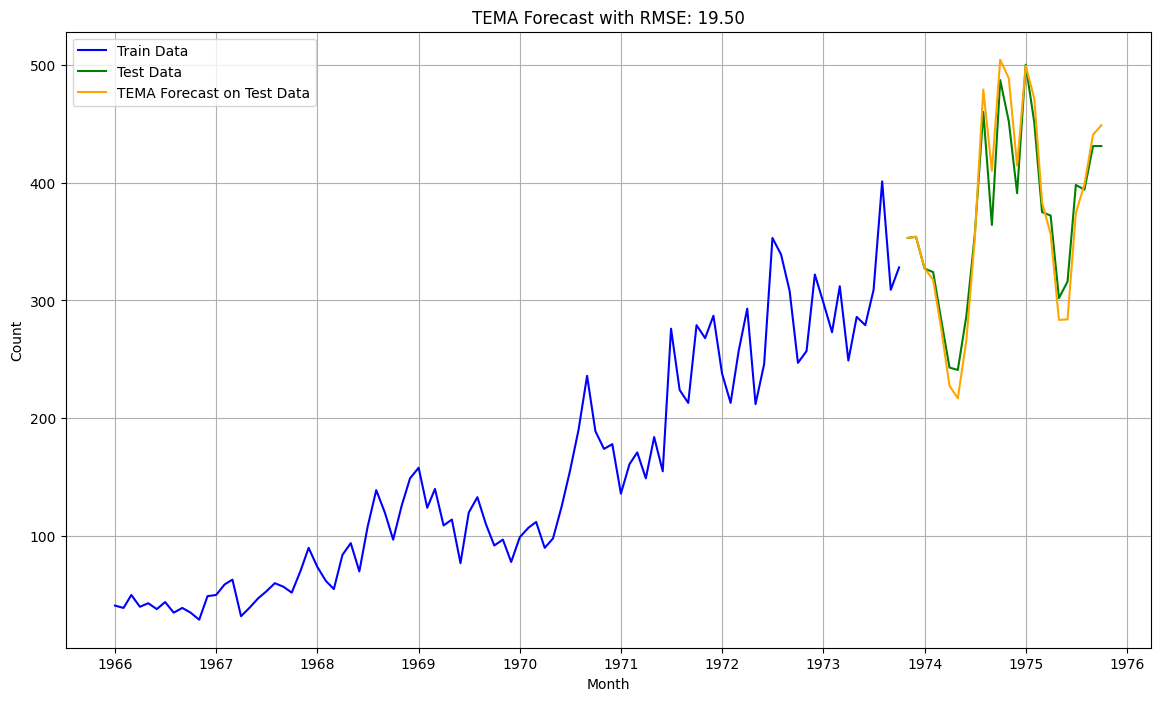

RMSE: 19.50


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Загрузка данных
robberies_in_boston = pd.read_csv('/content/monthly-boston-armed-robberies-j.csv')

# Преобразуем колонку 'Month' в формат даты и устанавливаем как индекс
robberies_in_boston['Month'] = pd.to_datetime(robberies_in_boston['Month'])
robberies_in_boston.set_index('Month', inplace=True)

# Разделение на тренировочные и тестовые данные
train_size = int(len(robberies_in_boston) * 0.8)
train, test = robberies_in_boston['Count'][:train_size], robberies_in_boston['Count'][train_size:]

# Параметры TEMA
span = 3  # период TEMA, можно варьировать

# Экспоненциальное скользящее среднее (EMA)
ema = train.ewm(span=span, adjust=False).mean()

# Двойное экспоненциальное скользящее среднее (DEMA)
de_ema = 2 * ema - ema.ewm(span=span, adjust=False).mean()

# Тройное экспоненциальное скользящее среднее (TEMA)
train_tema = 3 * ema - 3 * ema.ewm(span=span, adjust=False).mean() + ema.ewm(span=span, adjust=False).mean()

# Прогнозирование на тестовом наборе
test_tema = 3 * test.ewm(span=span, adjust=False).mean() - 3 * test.ewm(span=span, adjust=False).mean().ewm(span=span, adjust=False).mean() + test.ewm(span=span, adjust=False).mean().ewm(span=span, adjust=False).mean()

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(test, test_tema))

# Визуализация
plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, test_tema, label='TEMA Forecast on Test Data', color='orange')
plt.title(f'TEMA Forecast with RMSE: {rmse:.2f}')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

print(f"RMSE: {rmse:.2f}")


Расчет параметров alpha, beta, gamma

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Функция для вычисления RMSE для различных параметров
def evaluate_model(alpha, beta, gamma):
    result = triple_exponential_smoothing(robberies_in_boston['Count'], season_len, alpha, beta, gamma, 0)
    mse = mean_squared_error(robberies_in_boston['Count'], result[:len(robberies_in_boston)])
    rmse = np.sqrt(mse)
    return rmse

# Пробуем разные параметры
best_rmse = float('inf')
best_params = (0, 0, 0)

for alpha in np.arange(0.1, 1, 0.1):
    for beta in np.arange(0.1, 1, 0.1):
        for gamma in np.arange(0.1, 1, 0.1):
            rmse = evaluate_model(alpha, beta, gamma)
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (alpha, beta, gamma)

print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)


<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - series[i]) / season_len)
<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - series[i]) / season_len)
<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - serie

Best parameters: (0.8, 0.1, 0.8)
Best RMSE: 4.446862237123701


<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - series[i]) / season_len)
<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - series[i]) / season_len)
<ipython-input-17-6e72481f7eef>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_sum += (float(series[i + season_len] - serie

# Почему TEMA подходит.
TEMA (Тройное экспоненциальное скользящее среднее) был выбран из-за его способности улавливать тренд и сглаживать данные, что помогает при анализе нестационарного временного ряда с трендом и увеличивающейся дисперсией.

# 2. Стационарный временной ряд.

построим график для визуализации данных из female_births

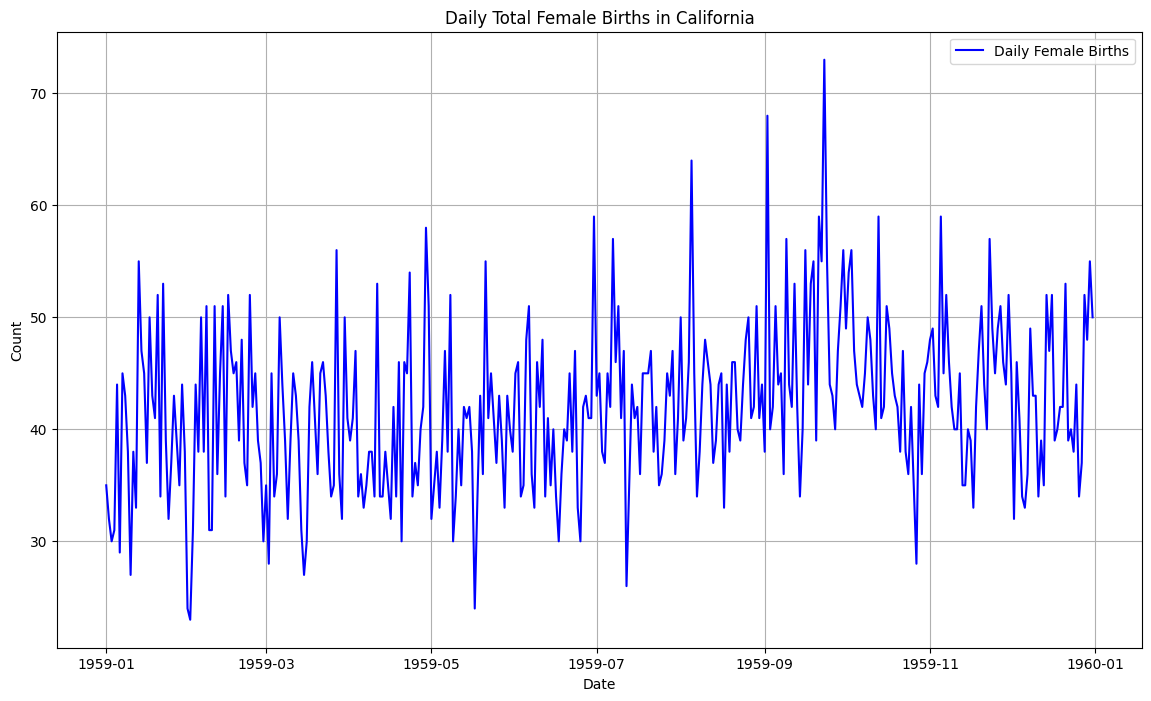

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

# Преобразование 'Date' в формат даты
female_births['Date'] = pd.to_datetime(female_births['Date'])

# Построение графика
plt.figure(figsize=(14, 8))
plt.plot(female_births['Date'], female_births['Count'], label='Daily Female Births', color='blue')
plt.title('Daily Total Female Births in California')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


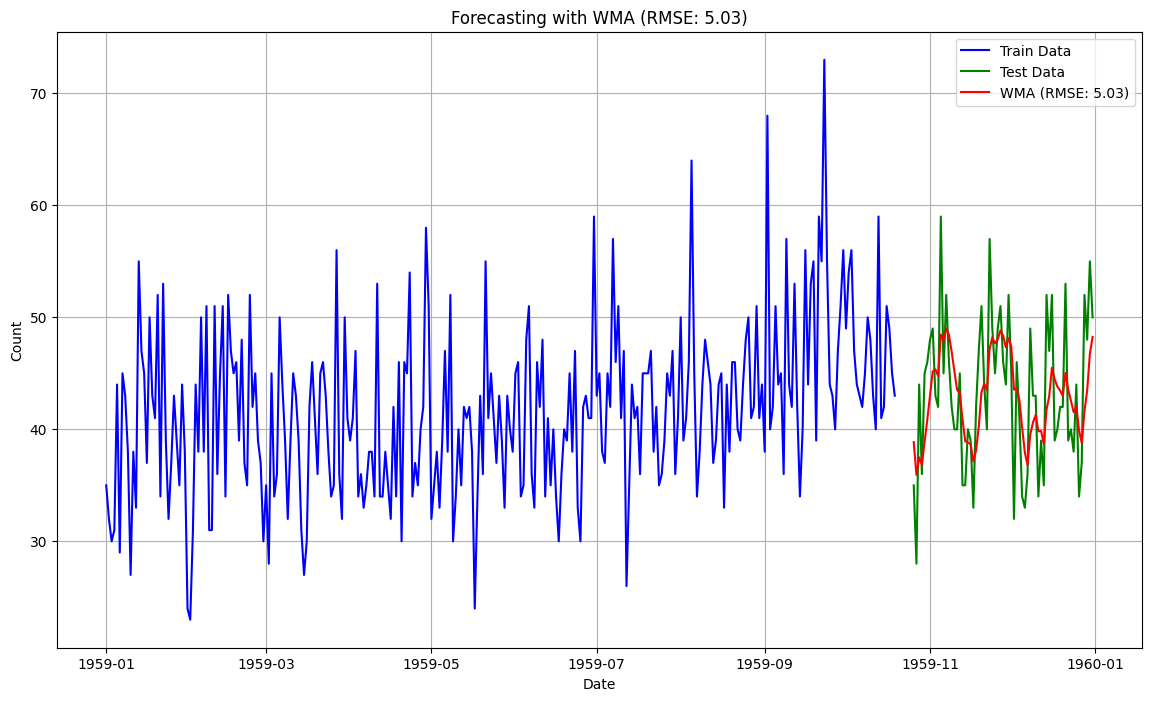

RMSE for WMA: 5.03


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Загрузка данных
female_births = pd.read_csv("/content/daily-total-female-births-in-cal.csv")

# Преобразование 'Date' в формат даты
female_births['Date'] = pd.to_datetime(female_births['Date'])

# Устанавливаем индекс
female_births.set_index('Date', inplace=True)

# Разделение данных на обучающую и тестовую выборки (80% на обучение, 20% на тестирование)
train_size = int(len(female_births) * 0.8)
train, test = female_births['Count'][:train_size], female_births['Count'][train_size:]

# Параметры
window_size = 7  # Период для скользящего среднего (например, 7 дней)

# Взвешенное скользящее среднее (WMA)
weights = np.arange(1, window_size + 1)
train_wma = train.rolling(window=window_size).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Прогнозирование на тестовой выборке (с применением WMA)
test_wma = test.rolling(window=window_size).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Убираем первые window_size-1 значения теста и прогноза для корректного сравнения
test_wma = test_wma[window_size-1:]
test = test[window_size-1:]

# Вычисление RMSE для модели WMA
rmse_wma = np.sqrt(mean_squared_error(test, test_wma))

# Визуализация
plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, test_wma, label=f'WMA (RMSE: {rmse_wma:.2f})', color='red')
plt.title(f'Forecasting with WMA (RMSE: {rmse_wma:.2f})')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

# Вывод RMSE
print(f"RMSE for WMA: {rmse_wma:.2f}")


Выбрано  взвешенное скользящее среднее (WMA) т.к. требуется быстрое реагирование на резкие изменения. Белый шум характеризуется отсутствием тренда и сезонности, поэтому методы, сглаживающие резкие выбросы  WMA, могут более точно отражать распределение шумовых данных, избегая чрезмерного усреднения, как это бывает с экспоненциальными методами, где вклад старых значений остается высоким.